Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>

---

# Lab Session 4: Overfitting and Regularization

Jérémie DECOCK - Adrien EHRHARDT - Jesse READ

## Objectives

Earlier, we have used a **parametric model** (linear and polynomial regression, closed form and gradient descent, by hand and with `sklearn`!) to solve **regression problems**. And we used logistic regression, a **parametric model** on **classification tasks** and k-NN, a **non-parametric model** on classification **and** regression problems.

Today we will continue the exploration of these methods, with a specific emphasis on understanding and correcting issues with overfitting, with regularization, and the bias-variance tradeoff. 

**Note**: as in the previous labs, there are some differences in notation with the lecture slides. For instance, parameters are noted $w$ (machine learning community) in lectures but they are noted $\theta$ here (statistics community).

## Imports

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.utils import shuffle

## Warmup: Ordinary Least Squares

Implement ordinary least squares in the following function. It should return the vector of coefficients $\mathbf{\theta}$. You may ignore the `alpha` ($\lambda$ -- since the `lambda` keyword is already taken in Python) parameter for now; we will use that later. 

In [82]:
def least_squares(X: np.array, y: np.array, alpha: float=0.0) -> np.array:
    """
    Perform linear regression via least squares, return coefficient

    :param numpy.array X: design matrix (n-sample as rows, p features as columns)
    :param numpy.array y: response vector (p elements)
    :param numpy.array alpha: regularization parameter (aka lambda; between 0 and inf)
    :return: linear regression coefficient found via ols
    :rtype: numpy.array
    """
    if alpha == 0:
        theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    else:
        # Ridge regression with L2 regularization
        n_features = X.shape[1]
        I = np.identity(n_features)
        print(I)
        #A = X.T.dot(X) + alpha * I
        #b = X.T.dot(y)
        A = np.dot(X.T,X) + alpha*I
        b = np.dot(X.T, y)
        
        theta = np.linalg.inv(A).dot(b)

    return theta

## Synthetic Data

Toy data is not just for play. If we define and control the ground truth, we can check (and, thus, further develop) many theoretical properties of methods, in a way which is not possible with real-world data.

In the following cell, provide the function `generate` which should return two 1d arrays (`x` and `y`) each of length `n` such that `x[i]` is a number generated uniformly between 0 and 1, and `y[i]` is:
$$
    y_i \sim \mathcal{N}(\mathbf{x}_i\boldsymbol{\theta}_\star, \sigma^2)
$$
for $\boldsymbol\theta_\star = [0.3, -2]$ and $\sigma=0.5$; where $\mathbf{x}_i = [1, x_i]$.

In [42]:
def generate(n):
    x = np.random.rand(n)
    y = []
    theta_star = np.array([0.3,-2])
    sigma = 0.5
    for i in x:
        x_i = np.array([1,i]) 
        y.append(np.random.normal(x_i.dot(theta_star), sigma**2))
    return x,y


In [43]:
x, y = generate(n=10)
X = np.vstack([np.ones_like(x), x]).T

In [44]:
theta

array([-0.22370774, -1.29261299])

Complete the following block, to obtain predictions on the training data and calculate the residual sum of squares (RSS) error, $\sum_{i=1}^n (\hat y_i - y_i)$, and store the result in the variable `E_RSS`.

In [45]:
theta = least_squares(X, y)
y_pred = theta.dot(X.T)
E_RSS = np.sum(y_pred - y)
print(E_RSS)

1.1102230246251565e-16


How does this compare to the error we would get if we had available the true model (the same one used to generate the data)? Repeat the RSS calculation but for the predictions obtained from the true model $f_\star$; and this time store the result in the variable `E_RSS_val`:

In [46]:
theta_true = np.array([0.3, -2])
y_pred = theta_true.dot(X.T)

E_RSS_val = np.sum(y_pred - y)
print(E_RSS_val)

-0.02170057416317117


Those number should be pretty close, most of the time (for most data sets that you could generate), since (and it's worth taking a while to check/understand this) all assumptions for ordinary least squares, regarding the data and underlying model, have been met.

Let's have a look at what is going on:

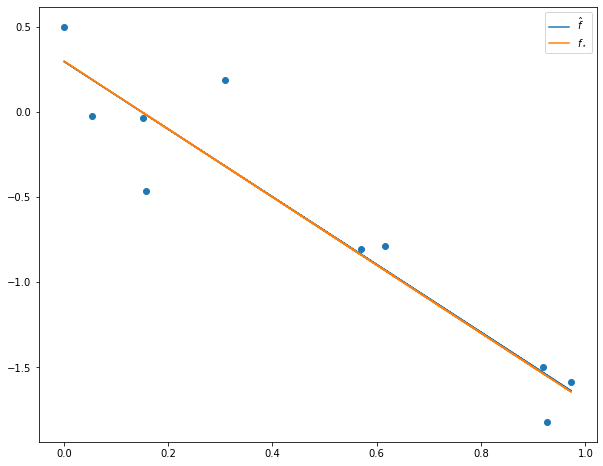

In [47]:
n = len(x)
X = np.vstack([np.ones_like(x),x]).T
theta=least_squares(X, y)
yp = X @ theta
yt = X @ theta_true
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y)
ax.plot(x, yp, label="$\hat f$")
ax.plot(x, yt, label="$f_\star$")
plt.legend()
plt.show()

## Unbiased Estimators 

In the following, check empirically if your implementation of least squares is an *unbiased estimator*. Hint: the derivation for this involves an expectation ($\mathbb{E}$) operator, but empirically you can replace this with a sum over many samples. You might check the slides/notes if you need a reminder/more information about what makes a model biased or not. 

In [59]:
print(theta_true)

# Of course, there are many ways to do this, it is the result (avg_theta) that counts... 
thetas = []
for _ in range(1000):
    x, y = generate(n=10)
    X = np.vstack([np.ones_like(x), x]).T
    theta_ = least_squares(X,y)
    thetas.append(theta_)
avg_theta = np.mean(thetas, axis=0)
print(avg_theta)

[ 0.3 -2. ]
[ 0.30439737 -2.00861006]


So far so good. However, things are not always so easy. Assumptions are often violated. In the following we look at 'pathological cases' where least sqaures is not going to sufficiently solve our learning problem. 

## Pathological Cases (Afflicting OLS)

Observe the effect with the following datasets. Identify the issue with each one (why does least squares fail).

In [51]:
X = np.array([[1, 2, 3, 4, 5], [2, 4, 6, 8, 10]]).T
y = np.array([1.8, 2.7, 3.4, 3.8, 3.9])

X

array([[ 1,  2],
       [ 2,  4],
       [ 3,  6],
       [ 4,  8],
       [ 5, 10]])

In [50]:
theta = least_squares(X, y)   # <- **TODO: UNCOMMENT**
theta                         # <- **TODO: UNCOMMENT**

LinAlgError: Singular matrix

The singular matrix error in OLS occurs when the design matrix (X) is not invertible, i.e., its determinant is equal to zero. This happens when there is perfect collinearity or linear dependence among the columns of the matrix, which means that one or more columns can be expressed as a linear combination of the other columns. This is a violation of the assumption that the x's are linearly independent

And what about this dataset:

In [70]:
X = np.array([[1, 3, 0],
              [2, 3, 4]])
y = np.array([1.8, 2.7])

X

array([[1, 3, 0],
       [2, 3, 4]])

In [71]:
theta = least_squares(X, y)   # <- **TODO: UNCOMMENT**
theta                         # <- **TODO: UNCOMMENT**

LinAlgError: Singular matrix

The independent variables are not linearly independent, which means they are collinear. The first column is just a constant term, but the second and third columns are not linearly independent, and the matrix X is not full rank. This makes it impossible for OLS to produce a unique solution for the coefficients of the regression equation.

In addition, the number of observations is smaller than the number of independent variables, which means the matrix X is not invertible, and there is no unique solution to the regression problem.


## Regularization with Ridge regression

Let's try a different dataset: 

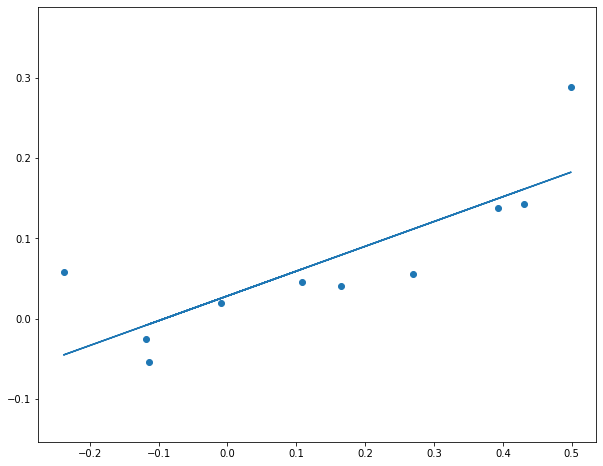

In [84]:
# Generate some data
np.random.seed(204)
x = np.random.rand(10) - 0.5
y = x**2 + np.random.randn(len(x)) * 0.05

# Build OLS
X = np.vstack([np.ones_like(x),x]).T
theta=least_squares(X, y)
yp = X @ theta

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y)
ax.plot(x, yp)
plt.ylim([min(y - 0.1),max(y + 0.1)])
plt.show()

Take a close look at the code for generating this data. Note how the dataset is generated from a *non-linear* function.

We apply basis expansion to fit a polynomial model to the data:

Coefs: [ 2.41506161e-02  7.55287932e-01 -3.25992224e+00 -3.07747620e+01
  1.58172204e+02  1.91040425e+02 -1.63707704e+03  1.85402258e+03
 -5.33013078e+01]


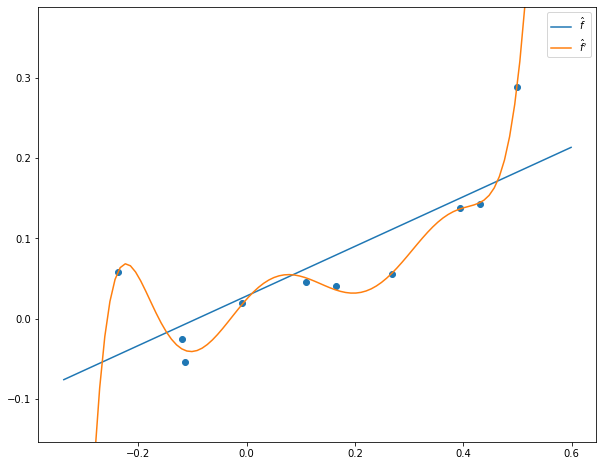

In [57]:
from sklearn.preprocessing import PolynomialFeatures
Z = PolynomialFeatures(degree=8, include_bias=True).fit_transform(x.reshape(-1,1))

# Instantiate and fit the model
poly_reg = sklearn.linear_model.LinearRegression(fit_intercept=False)
poly_reg.fit(Z, y)
theta_poly = poly_reg.coef_
print("Coefs:", theta_poly)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y)
xxx = np.linspace(min(x)-0.1,max(x)+0.1,100)
XXX = np.vstack([np.ones_like(xxx), xxx]).T
ax.plot(xxx, XXX @ theta, label="$\hat f$")
zzz = PolynomialFeatures(degree=8, include_bias=True).fit_transform(xxx.reshape(-1,1))
plt.plot(xxx,poly_reg.predict(zzz),label="$\hat f'$")
plt.ylim([min(y-0.1),max(y+0.1)])
plt.legend()
plt.show()

**Consider some of the issues here**, such as the number and magnitude of the coefficients, potential performance on the test data, in certain ranges of the $x$-domain.

A solution is to reduce the complexity of the model using a lower polynomial degree, e.g., with *ridge regularization* (a.k.a. *L2 regularization*) which applies a penalty on the values of $\theta_j$ to constrain them to be smaller. A parameter $\boldsymbol{\theta}$ with small magnitude usually makes the model simpler and brings better generalization performances. This L2 regularization is included in the least square method as follows:

$$
\boldsymbol{\theta}^*
\leftarrow \arg\min_{\boldsymbol{\theta}} E(\boldsymbol{\theta})
\quad \text{with} \quad
E(\boldsymbol{\theta})
= \underbrace{||\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta}||^2_2}_{\text{error term}} ~~ + \underbrace{\lambda ||\boldsymbol{\theta}||^2_2}_{\text{regularization}}$$

where $\lambda \in \mathbb{R}^+$ is the *regularization strength* coefficient:
- when $\lambda$ goes to infinity, the regularization term dominates the error term (MSE) and the coefficients $\boldsymbol{\theta}$ tend to zero;
- when $\lambda$ goes to 0, the regularization term looses the importance and eventually the regularization term is ignored;
- $\lambda$ is a *meta* or *hyper parameter*;
- the best $\lambda$ for a problem can be estimated empirically, we look at this soon!


On a sheet of paper:
- Compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$
- Compute the analytic formulation of the optimal parameter $\boldsymbol{\theta^*}$

*Note*: this is very similar to [`lab_session_02`](https://adimajo.github.io/CSE204-2022-admin/lab_session_02.html).

To compute the gradient of $\mathbb{E}(\theta)$ we first expand the term as follows
$$\|y-X\theta\|_2^2=y^Ty-y^TX\theta-\theta^TX^Ty+\theta^TX^TX\theta$$
We then take the derivative w.r.t $\theta$ and we get
$$\nabla_\theta\|y-X\theta\|_2^2=2(X^TX\theta-X^Ty)$$
Similarly, we take the derivative of the regularization term, we get
$$\nabla_\theta\lambda\|\theta\|_2^2=2\lambda\theta$$
Finally, we add the two terms and we get
$$\nabla_\theta\mathbb{E}(\theta)=2(X^TX\theta-X^Ty)+2\lambda\theta$$

To find the optimal parameter $\theta^*$, we set teh gradient to 0 and solve for $\theta$

$$\begin{align*}
\nabla_\theta\mathbb{E}(\theta) &= 0\\
2(X^TX\theta-X^Ty)+2\lambda\theta &=0\\
(X^TX+\lambda I)\theta &= X^Ty\\
\theta &= (X^TX+\lambda I)^{-1}X^Ty\\
\end{align*}$$

Where $I$ is the identity matrix. Therefore the optimal parameter is given by
$$\theta^*=(X^TX+\lambda I)^{-1}X^T y$$

**Question**: Is it a convex optimization problem like *Ordinary Least Squares*? Why?

Yes, the optimization problem is convex.
We note that the first term $||\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta}||^2_2$ is a quadratic function of $\boldsymbol{\theta}$, which is a convex function. The second term $\lambda ||\boldsymbol{\theta}||^2_2$ is also a quadratic function of $\boldsymbol{\theta}$, which is a convex function. Therefore, the sum of two convex functions is also a convex function.



Check the following Scikit Learn implementation of the Ridge Regression (more info here: https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression ). In particular: Change the `alpha` ($\lambda$) and `k`/degree parameters, and observe the results. 

# MALLLLLLLLLLLLLLLLLLLLLLLLLl

Coefs: [-7.35512340e-01  3.10039226e+01 -1.81464138e+02 -2.39068575e+03
  1.70132557e+04  2.07786383e+03 -2.20837808e+05  5.26245992e+05
 -3.73481895e+05]


TypeError: unsupported operand type(s) for -: 'list' and 'float'

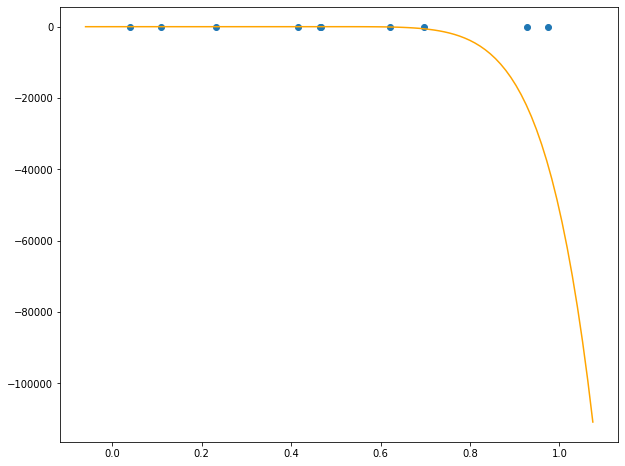

In [67]:
# Set hyper-parameters
alpha=0 # regularization #TODO change to, e.g., 0.1, 1, etc.
k=8 # degree polynomial  #TODO change to, e.g., 8, 4, 2, etc.

# Fit ridge regression
poly_ridge = sklearn.linear_model.Ridge(alpha=alpha, fit_intercept=False)
poly_ridge.fit(Z, y)

# Have a look at the coefficients
coefs = [poly_ridge.intercept_] + poly_ridge.coef_
print("Coefs:", coefs)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y)
xxx = np.linspace(min(x)-0.1,max(x)+0.1,100)
zzz = PolynomialFeatures(degree=k, include_bias=True).fit_transform(xxx.reshape(-1,1))
plt.plot(xxx,poly_ridge.predict(zzz),label="$\hat f$ (deg. %d, $\lambda=%3.2f$)" % (k,alpha), color='orange')
plt.ylim([min(y-0.1),max(y+0.1)])
plt.legend()
plt.show()

In the following, plot the ridge coefficients as a function of the regularization parameter.

Evaluate the following sequence of regularization strength: `alphas = np.logspace(-2, 5, 50)`.

In [68]:
# Compute paths
alphas = np.logspace(-2, 5, 50)

coefs = []
for a in alphas:
    # Fit a `Ridge` object
    poly_ridge = sklearn.linear_model.Ridge(alpha=a, fit_intercept=False)
    poly_ridge.fit(Z,y)
    coefs_ = [poly_ridge.intercept_] + poly_ridge.coef_
    coefs.append(coefs_)  # TO UNCOMMENT: append the ridge coefficients to the `coefs` list

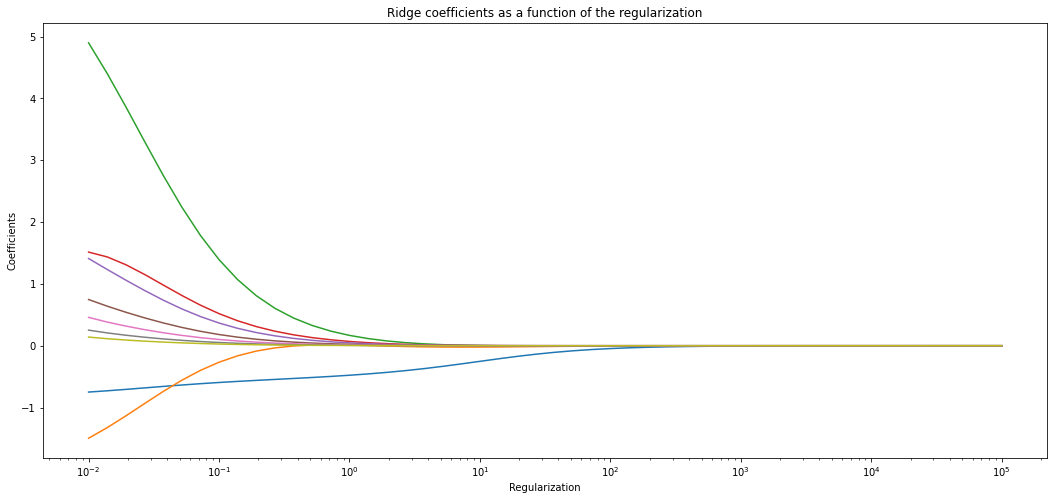

In [69]:
# Display results
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('Regularization')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Return to the function `least_squares` that you implemented already above; now update the function to implement the ridge regression in Python (*without* using Scikit-Learn). The ridge/regularization should 'take effect' *only when* `alpha > 0`. Observe your result in the following (you can experiment with `k` and `alpha` again):

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Coefs: [0.01730987 0.20085167 0.32757512]


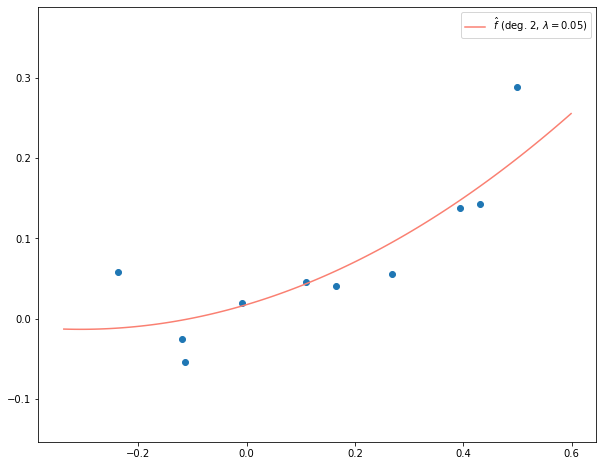

In [85]:
# Set the hyper-parameters
k = 2
alpha = 0.05

# Test your function
Z = PolynomialFeatures(degree=k, include_bias=True).fit_transform(x.reshape(-1,1))
theta_ridge = least_squares(Z, y, alpha=alpha)
print("Coefs:", theta_ridge)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y)
xxx = np.linspace(min(x)-0.1,max(x)+0.1,100)
zzz = PolynomialFeatures(degree=k, include_bias=True).fit_transform(xxx.reshape(-1,1))
plt.plot(xxx,zzz @ theta_ridge,label="$\hat f$ (deg. %d, $\lambda=%3.2f$)" % (k,alpha), color='salmon')
plt.ylim([min(y-0.1),max(y+0.1)])
plt.legend()
plt.show()

## Ridge Logistic Regression

In the following we generate and plot a toy dataset for classification.

In [86]:
def gen_2d_classification_samples(n: int = 20) -> np.array:
    """
    Generates 2-dimensional samples, which belong to either of 2 classes

    :param int n: number of samples to draw per class
    :returns: two arrays of X (shape (n,2)) and y (shape (n,)
    """
    y = ((np.random.rand(n) >= 0.5) * 1).astype(int)
    X = np.random.randn(n,2) * 0.5 + (y.reshape(n,-1) == 1) * 1
    
    return X, y

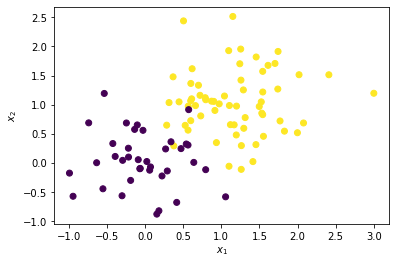

In [87]:
X,y = gen_2d_classification_samples(100)
x_min, x_max = np.array((X[:,0], X[:,1]))[0, :].min() - .5, np.array((X[:,0], X[:,1]))[0, :].max() + .5
y_min, y_max = np.array((X[:,0], X[:,1]))[1, :].min() - .5, np.array((X[:,0], X[:,1]))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(X[:,0], X[:,1], c=y);

We used gradient descent to fit a Logistic Regression, which finds a linear decision boundary between these two classes.

In [88]:
# Recall the `LogisticRegression` class:
logistic_regression = sklearn.linear_model.LogisticRegression(C=1e9).fit(X,y)

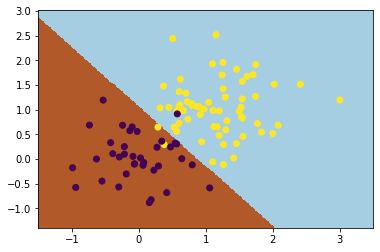

In [89]:
Z = logistic_regression.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
plt.pcolormesh(xx, yy, (Z.reshape(xx.shape) > 0.5) * 1, cmap=plt.cm.Paired)
plt.scatter(X[:,0], X[:,1], c=y);

Let's try to do polynomial logistic regression:

In [90]:
fil = PolynomialFeatures(degree=7, include_bias=True)
Phi = fil.fit_transform(X)

logistic_regression = sklearn.linear_model.LogisticRegression(C=1e9, solver='liblinear').fit(Phi,y)

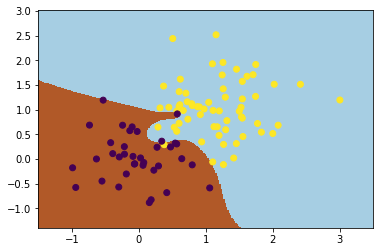

In [91]:
xxxx = np.c_[xx.ravel(), yy.ravel()]
phi_ = fil.transform(xxxx)
Z = logistic_regression.predict_proba(phi_)[:,0]
plt.pcolormesh(xx, yy, (Z.reshape(xx.shape) > 0.5) * 1, cmap=plt.cm.Paired)
plt.scatter(X[:,0],X[:,1],c=y);

You might observe a relatively poor fit. Just like linear regression, let's try to regularize logistic regression with a ridge penalty ($\lambda ||\boldsymbol{\theta}||_2^2$).
On a sheet of paper (that you drag-and-drop in the cell below or in $\LaTeX$), compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$.

*Note*: this is similar to above **but** the error function is now the log-loss.

YOUR ANSWER HERE

We can use the `C` parameter in `sklearn`, inversely proportional to $\lambda$, to fit such a penalization.

In [ ]:
# Lower C means more regularization (higher alpha) - you may edit C:
logistic_regression = sklearn.linear_model.LogisticRegression(C=0.1, solver='liblinear', penalty='l2').fit(Phi,y)

In [ ]:
xxxx = np.c_[xx.ravel(), yy.ravel()]
phi_ = fil.transform(xxxx)
Z = logistic_regression.predict_proba(phi_)[:,0]
plt.pcolormesh(xx, yy, (Z.reshape(xx.shape) > 0.5) * 1, cmap=plt.cm.Paired)
plt.scatter(X[:,0],X[:,1],c=y);

### Cross Validation and Hyper-Parameter Tuning

What value of `C` should we use? Consider the potential values listed in `c_range` in the following code block. Make use of the `cross_val_score` function which will handle cross validation for you. You should do 10-fold cross validation, under the 'accuracy' scoring metric; use logistic regression as the `estimator`, and the `PolynomialFeatures` (degree 7) `Phi`, as produced recently (above). Consider the average accuracy across the 10 folds as the 'value' of each `C`-value; choose the one you prefer and put it in `c_selected`.

*Hint*: see [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [ ]:
# This is the kind of model you should test on: 
# sklearn.linear_model.LogisticRegression(C=c, solver='liblinear', penalty='l2')

# ... for the following values of c: 
c_range = [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 1000]

# Make use of the following 
from sklearn.model_selection import cross_val_score

In [ ]:
# You should update the following variable with your choice
c_selected = c_range[0]

# YOUR CODE HERE
raise NotImplementedError()

## Weighted Least Squares (Bonus)

In [ ]:
def gen_1d_polynomial_regression_samples(n_samples: int = 15) -> pd.DataFrame:
    """
    Generate 1-dimensional regression samples (x, y)

    :param int n_samples: how many samples to return
    """
    x = np.random.uniform(low=0., high=1.5, size=n_samples)
    y = np.cos(2. * np.pi * x) + np.random.normal(scale=0.1, size=x.shape)
    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df = sklearn.utils.shuffle(df).reset_index(drop=True)
    return df

In [ ]:
def plot_regression_1d(X, y, theta=None, x_min=0, x_max=2):
    """
    Plot linear regression of X on y given theta
    """
    assert X.ndim == 2 and X.shape[1] == 2, X.shape
    assert y.ndim == 2 and y.shape[1] == 1, y.shape
    if theta is not None:
        assert theta.ndim == 2 and theta.shape == (2, 1), theta.shape
    
    fig, ax = plt.subplots()
    ax.scatter(X[:,1], y)

    if theta is not None:
        x = np.linspace(x_min, x_max, 50)
        y = theta[0] + theta[1] * x

        ax.plot(x, y, "--r")

In [ ]:
def plot_1d_regression_samples(dataframe: pd.DataFrame, model=None):
    """
    Plot the data in dataframe, as wellas (optionnally) the predictions from a model

    :param pandas.DataFrame dataframe: dataframe containing 'x' and 'y'
    :param model: model to predict
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    df = dataframe.copy()  # make an alias
    
    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x', 'y']"
    assert df.columns.values.tolist() == ['x', 'y'], ERROR_MSG1
    
    if model is not None:
        
        # Compute the model's prediction
        x_pred = np.linspace(df.x.min(), df.x.max(), 100).reshape(-1, 1)
        y_pred = model.predict(x_pred)
        df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])
        df_pred.plot(x='x', y='y', style='r--', ax=ax)

    # Plot also the training points
    df.plot.scatter(x='x', y='y', ax=ax)
    delta_y = df.y.max() - df.y.min()
    plt.ylim((df.y.min() - 0.15 * delta_y,
              df.y.max() + 0.15 * delta_y))

For some regression problems, it may be helpful to give different importance to examples in the *learning set* $\mathcal{D} = \{(\boldsymbol{x^{(i)}}, y^{(i)})\}_{1 \leq i \leq n}$ that is to say associate a weight $\omega^{(i)}$ to example $\boldsymbol{x}^{(i)}$ in order to prioritize some of them and ignore some others (e.g. outliers).
Introducing these weights in the method of Least Square, the regression problem becomes:

$$E(\boldsymbol{\theta}) = \sum_{i=1}^n \omega^{(i)} (y^{(i)} - \boldsymbol{x}^{(i)} \boldsymbol{\theta})^2.$$

In order to use the matrix notation, we put weights $\omega^{(i)}$ in the diagonal of the following matrix $\Omega$:

$$
\Omega =
\begin{pmatrix}
\omega^{(1)} & 0            & \cdots & 0 \\
0            & \omega^{(2)} & \cdots & 0 \\
\vdots       & \vdots       & \ddots & \vdots \\
0            & 0            & \cdots & \omega^{(n)} \\
\end{pmatrix}
$$

Then we can write:

$$E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^T \Omega (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})$$

with:
$$
\boldsymbol{X} = \begin{pmatrix} 1 & x_1^{(1)} & \dots & x_p^{(1)} \\ \vdots & \vdots & \dots & \vdots \\ 1 & x_1^{(n)} & \dots & x_p^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} y^{(1)} \\ \vdots \\ y^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_0 \\ \vdots \\ \theta_p \end{pmatrix}
$$


On a sheet of paper (that you drag-and-drop in the following cell or with $\LaTeX$):
- Compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$
- Compute the analytic formulation of the optimal parameter $\boldsymbol{\theta^*}$

*Note*: this is again very similar to question 2.1.

YOUR ANSWER HERE

Is this problem a convex optimization problem like *Ordinary Least Squares*? Why?

YOUR ANSWER HERE

We have the following dataset and weights:

In [ ]:
X = np.array([[1, 1],
              [1, 2],
              [1, 3],
              [1, 4],
              [1, 5]])

y = np.array([1.8, 4.5, 3.4, 3.6, 4.2]).reshape([-1, 1])

Omega = np.diag([1, 2, 3, 2, 1])

Omega

In [ ]:
plt.scatter(X[:,1], y);

Complete the following Python implementation of the `weighted_least_squares()` procedure.
It should return the optimal parameter $\boldsymbol{\theta^*}$ using the method of Least Square for the matrix of weights $\Omega$ defined above. Here, we expect $\theta$ to be a Numpy array of shape `(1, 2)` (i.e. a vector of two elements).

*Numpy hints*:
- The transpose of a matrix `X` is obtained with `X.T`
- The inverse of a matrix `X` is obtained with `np.linalg.inv(X)`
- The product of two matrices `X` and `Y` is obtained with `np.dot(X, Y)` or `np.matmul(X, Y)` or `X @ Y`
- The dot product of a matrix `X` and a vector `y` is obtained with `np.dot(X, y)`

In [ ]:
def weighted_least_squares(X, Omega, y):
    # theta = ...  # TO UNCOMMENT AND COMPLETE
    # YOUR CODE HERE
    raise NotImplementedError()
    return theta

In [ ]:
theta = weighted_least_squares(X, Omega, y)
assert len(theta) == 2

Check graphically your model using the following code:

In [ ]:
plot_regression_1d(X, y, theta, x_min=0, x_max=6)

This is arguably relatively bad, since it seems the second point might be an outlier and "drags" the regression line.

#### 4.4
Change the weights in $\Omega$ to ignore the second point $x = 2$ (give the same weight to all other points) then recompute $\theta$ using `weighted_least_squares()` and check the results on plots with `plot_regression_1d()`.

In [ ]:
# Omega = ...
# YOUR CODE HERE
raise NotImplementedError()
theta = weighted_least_squares(X, Omega, y)
plot_regression_1d(X, y, theta, x_min=0, x_max=6)

In [ ]:
assert len(theta) == 2

## Nadaraya-Watson Kernel Regression (Bonus)

Like k-Nearest Neighbors, *Nadaraya-Watson Kernel Regression* is a **non-parametric** model, i.e. decisions are made according to known examples from the *learning set* $\mathcal{D} = \{(y^{(i)}, \boldsymbol{x^{(i)}})\}_{1 \leq i \leq n}$ of $n$ examples and considering a kind of proximity relationship.

With k-Nearest Neighbors, decisions are based only on the closest neighbors and other examples are simply ignored. If you remember correctly from the end of Lab 03, we used `sklearn`'s implementation of k-Nearest Neighbors and its `weights="distance"` option to use the label of the nearest neighbors **proportionally to their distance from the point to predict**.
Contrary to standard k-NN but in the same fashion as the aforementioned option, with Kernel Regression all examples $(\boldsymbol{x}^{(i)}, y^{(i)})$ from $\mathcal{D}$ are used to predict the label $y$ of any new point $\boldsymbol{x}$, but their respective contribution in this prediction is weighted using a *kernel function* $K(\boldsymbol{x}^{(i)}, \boldsymbol{x})$. 

$$
\hat{y}
= f(\boldsymbol{x})
= \frac{\sum^{n}_{i=1} K(\boldsymbol{x}^{(i)}, \boldsymbol{x}) ~ y^{(i)}}{\sum^{n}_{j=1} K(\boldsymbol{x}^{(j)}, \boldsymbol{x})}
= \sum^{n}_{i=1} y^{(i)} \omega^{(i)}
$$

with $\sum^{n}_{i=1} \omega^{(i)} = 1$

Recall about the notation used here:
- $\boldsymbol{x}^{(i)}$ is the feature (input) vector of the $i^{\text{th}}$ example in $\mathcal{D}$ (and $y^{(i)}$ is its label). Beware: $\boldsymbol{x}^{(i)}$ is not the $i^{\text{th}}$ power of $\boldsymbol{x}$ (we will write $\boldsymbol{x}^{(i)2}$ for the square of $\boldsymbol{x}^{(i)}$)!
- $x_i$ is the value of $\boldsymbol{x}$ on the $i^{\text{th}}$ dimension

Implement the Gaussian kernel $K$ in the following `gaussian_kernel()` Python function.

$$
K(\boldsymbol{u}, \boldsymbol{v})
= \exp\left(\frac{-||\boldsymbol{u} - \boldsymbol{v}||^2_2}{2 \sigma^2} \right)
$$

where $\sigma$ is a parameter equal to $1$ by default.

You can assume $u$ and $v$ to be simple scalars to simplify this Python implementation (i.e. restrict yourself to regression problem with 1 dimension inputs $x \in \mathbb{R}$).

Recall: $e^x$ is written `math.exp(x)` in Python.

In [ ]:
def gaussian_kernel(u, v, sigma = 1.):
    # return expression above
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert gaussian_kernel(0,0) == 1
assert gaussian_kernel(1,0) == math.exp(-1/2)

Implement the Nadaraya-Watson kernel regression in the following `kernel_regression()` Python function.

$$
\text{kernel_regression}(\boldsymbol{x}, \mathcal{D})
= \frac{\sum^{n}_{i=1} K(\boldsymbol{x}^{(i)}, \boldsymbol{x}) ~ y^{(i)}}{\sum^{n}_{j=1} K(\boldsymbol{x}^{(j)}, \boldsymbol{x})}
= \hat{y}
$$

You can assume that $x$ is a scalar to simplify the Python implementation.
We assume `dataset` contains examples $\mathcal{D} = \{(\boldsymbol{x^{(i)}}, y^{(i)})\}_{1 \leq i \leq n}$ in a Pandas DataFrame having:
- one row per example
- a column "x" containing the examples' features (only one dimension here)
- a column "y" containing the examples' labels

**Hint**: you can use the following `for` loop to compute $\sum K(\boldsymbol{x}^{(i)}, \boldsymbol{x}) ~ y^{(i)}$: `for xi, yi in zip(df.x, df.y)`.

In [ ]:
def kernel_regression(x, dataset):
    # Hint: calculate numerator and denominator separately with list comprehensions
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert kernel_regression(1, pd.DataFrame({"x": [0], "y": [0]})) == 0

We have the following dataset:

In [ ]:
dataset = pd.DataFrame([[2., 0.],
                        [5., 2.],
                        [7., 1.],
                        [10., 2.],
                        [14., 4.],
                        [16., 3.],
                        [17., 0.]], columns=['x', 'y'])
dataset

Check your `kernel_regression()` function with the following code:

In [ ]:
x_pred = np.linspace(0., 20., 200)
y_pred = [kernel_regression(x, dataset) for x in x_pred]

ax = dataset.plot.scatter(x='x', y='y', label="Dataset", figsize=(12,8))
ax.plot(x_pred, y_pred, "-r", label="Kernel regression")
plt.legend();